## PROPHET

In [48]:
from prophet import Prophet


In [49]:
df_p = pd.read_csv('Cleaned.csv')

### Data preparation for prophet modelling

In [50]:

# Forecast Avocado wholesale price in Kisumu (Ahero Market)
df_prophet = df_p[(df_p["Commodity"] == "Avocado") & (df_p["Market"] == "Ahero") & (df_p["County"] == "Kisumu")]

# Prophet requires 'ds' (date) and 'y' (value) columns
prophet_df = df_prophet[["Date", "WholesaleUnitPrice"]].rename(columns={"Date": "ds", "WholesaleUnitPrice": "y"})


### Fit the prophet model & forecast into the future

In [51]:

model = Prophet(
    yearly_seasonality=True,    # Captures yearly price cycles (harvest/off-season)
    weekly_seasonality=True,    # Captures weekly market trends
    daily_seasonality=False     # Daily not needed unless intraday data
)
model.fit(prophet_df)


# Forecast into the Future
future = model.make_future_dataframe(periods=60)  # Forecast 60 days ahead
forecast = model.predict(future)

16:02:06 - cmdstanpy - INFO - Chain [1] start processing
16:02:09 - cmdstanpy - INFO - Chain [1] done processing


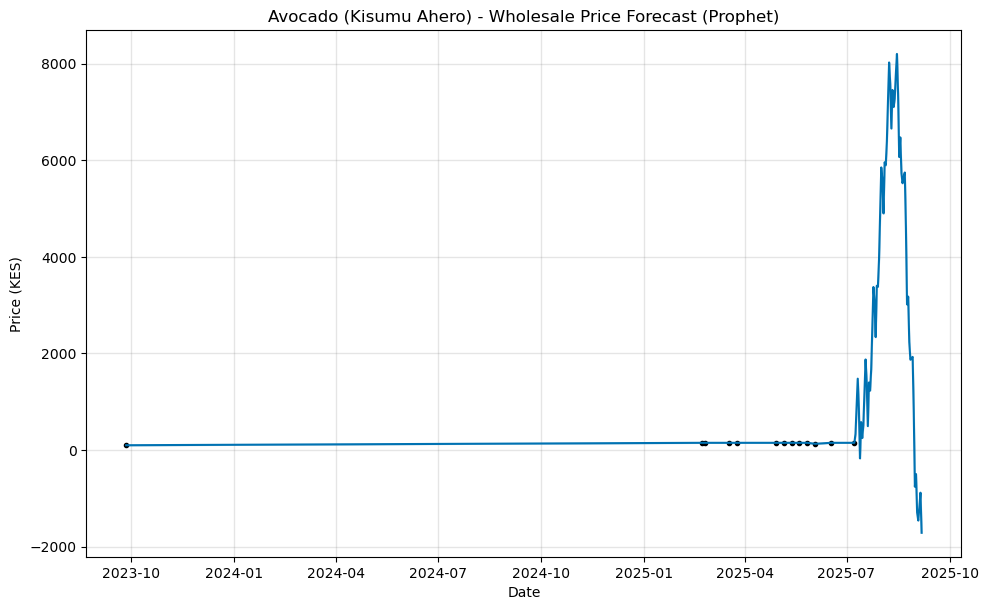

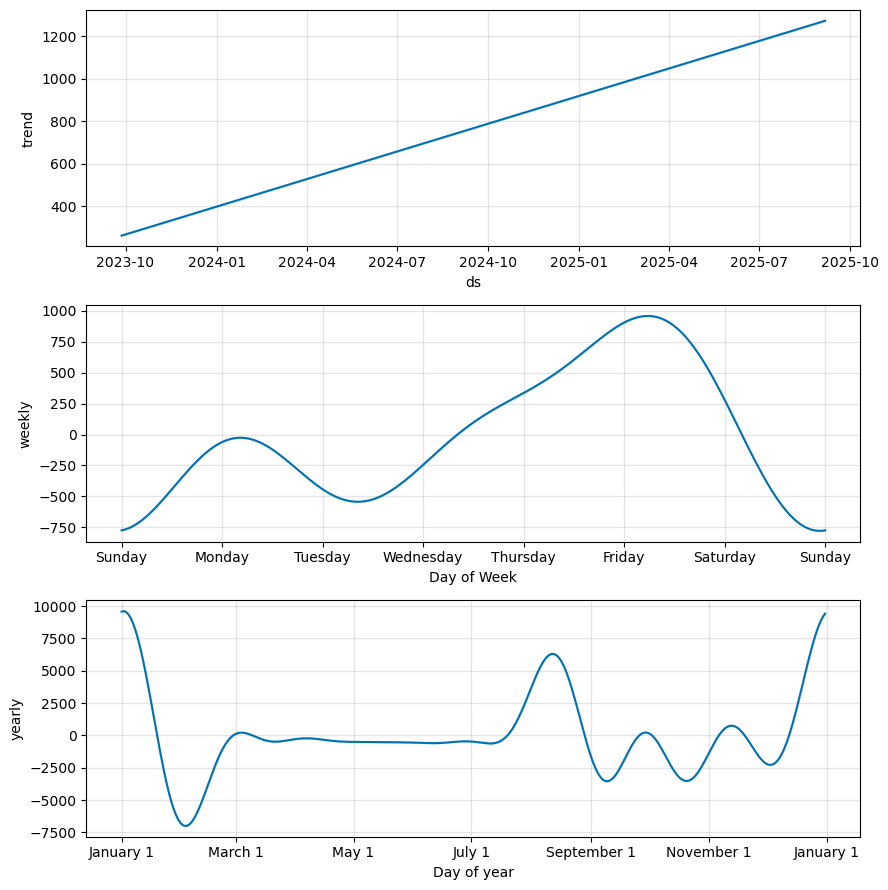

In [52]:
# Plot Forecast
fig1 = model.plot(forecast)
plt.title("Avocado (Kisumu Ahero) - Wholesale Price Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Price (KES)")
plt.show()

# Plotting forecast components (trend + seasonality breakdown)
fig2 = model.plot_components(forecast)
plt.show()

### Batch Prophet Forecasting Pipeline

In [53]:
# How many days into the future to forecast
FORECAST_HORIZON = 60

# Container for all forecasts
all_forecasts = []

# Group by Commodity + Market + County
for (commodity, market, county), group in df.groupby(["Commodity", "Market", "County"]):
    group = group.sort_values("Date")

    # Skipping groups with very few data points (Prophet needs some history)
    if len(group) < 20:
        continue

    # Preparing data for Prophet (Wholesale)
    df_wholesale = group[["Date", "WholesaleUnitPrice"]].rename(columns={"Date": "ds", "WholesaleUnitPrice": "y"})
    model_wholesale = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_wholesale.fit(df_wholesale)
    future_wholesale = model_wholesale.make_future_dataframe(periods=FORECAST_HORIZON)
    forecast_wholesale = model_wholesale.predict(future_wholesale)
    forecast_wholesale["Commodity"] = commodity
    forecast_wholesale["Market"] = market
    forecast_wholesale["County"] = county
    forecast_wholesale["Price_Type"] = "Wholesale"
    all_forecasts.append(forecast_wholesale[["ds", "yhat", "yhat_lower", "yhat_upper", "Commodity", "Market", "County", "Price_Type"]])

    # Preparing data for Prophet (Retail)
    df_retail = group[["Date", "RetailUnitPrice"]].rename(columns={"Date": "ds", "RetailUnitPrice": "y"})
    model_retail = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_retail.fit(df_retail)
    future_retail = model_retail.make_future_dataframe(periods=FORECAST_HORIZON)
    forecast_retail = model_retail.predict(future_retail)
    forecast_retail["Commodity"] = commodity
    forecast_retail["Market"] = market
    forecast_retail["County"] = county
    forecast_retail["Price_Type"] = "Retail"
    all_forecasts.append(forecast_retail[["ds", "yhat", "yhat_lower", "yhat_upper", "Commodity", "Market", "County", "Price_Type"]])

# Combining all forecasts into one DataFrame
final_forecasts = pd.concat(all_forecasts, ignore_index=True)

# Save to CSV for later use
final_forecasts.to_csv("commodity_price_forecasts.csv", index=False)

print("Batch forecasting complete! Saved to 'commodity_price_forecasts.csv'.")
print(final_forecasts.head())


16:02:12 - cmdstanpy - INFO - Chain [1] start processing
16:02:12 - cmdstanpy - INFO - Chain [1] done processing
16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:13 - cmdstanpy - INFO - Chain [1] done processing
16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:14 - cmdstanpy - INFO - Chain [1] done processing
16:02:15 - cmdstanpy - INFO - Chain [1] start processing
16:02:15 - cmdstanpy - INFO - Chain [1] done processing
16:02:16 - cmdstanpy - INFO - Chain [1] start processing
16:02:17 - cmdstanpy - INFO - Chain [1] done processing
16:02:17 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
16:02:19 - cmdstanpy - INFO - Chain [1] start processing
16:02:20 - cmdstanpy - INFO - Chain [1] done processing
16:02:21 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1]

Batch forecasting complete! Saved to 'commodity_price_forecasts.csv'.
          ds       yhat  yhat_lower  yhat_upper Commodity Market County  \
0 2023-08-23  19.222695   16.101133   22.435184   Avocado  Akala  Siaya   
1 2024-06-05   8.203320    5.317814   11.357559   Avocado  Akala  Siaya   
2 2024-06-08  13.869226   10.816207   16.954569   Avocado  Akala  Siaya   
3 2024-06-13  15.643993   12.352401   18.636792   Avocado  Akala  Siaya   
4 2024-06-26  11.464681    8.385971   14.938271   Avocado  Akala  Siaya   

  Price_Type  
0  Wholesale  
1  Wholesale  
2  Wholesale  
3  Wholesale  
4  Wholesale  


What this does:
1. Iterates over every commodity-market-county combination.

2. Fits two Prophet models (Wholesale and Retail) for each series.

3. Forecasts 60 days ahead with uncertainty intervals (yhat_lower, yhat_upper).

4. Stores all results into a single CSV.

In [54]:

# Selecting top 5 commodities by record count (to avoid sparse series)
top_commodities = df_p["Commodity"].value_counts().head(5).index

results = []

for commodity in top_commodities:
    for price_col, price_type in [("WholesaleUnitPrice", "Wholesale"), ("RetailUnitPrice", "Retail")]:
        
        # Filterint the series for this commodity (all markets/counties combined)
        df_series = df_p[df_p["Commodity"] == commodity][["Date", price_col]].rename(
            columns={"Date": "ds", price_col: "y"}
        ).dropna().sort_values("ds")
        
        # we will us this to skip if not enough history
        if len(df_series) < 90:  # 3 months of data minimum
            continue
        
        # Train/test split (last 60 days for testing)
        train = df_series.iloc[:-60]
        test = df_series.iloc[-60:]
        
        # Fit Prophet
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.fit(train)
        
        # Forecast for the test period
        future = model.make_future_dataframe(periods=60, freq='D')
        forecast = model.predict(future)
        
        # Align datetime columns
        forecast["ds"] = pd.to_datetime(forecast["ds"])
        test["ds"] = pd.to_datetime(test["ds"])
        
        # Align predictions to test dates
        pred_test = forecast.set_index("ds").reindex(test["ds"])["yhat"]
        
        # Reset index to avoid Timestamp vs Int alignment issues
        pred_test = pred_test.reset_index(drop=True)
        actual_test = test["y"].reset_index(drop=True)
        
        # Drop any rows with missing predictions or actuals
        mask = (~pred_test.isna()) & (~actual_test.isna())
        pred_test = pred_test[mask]
        actual_test = actual_test[mask]
        
        # Compute accuracy metrics
        mae = mean_absolute_error(actual_test, pred_test)
        rmse = mean_squared_error(actual_test, pred_test, squared=False)
        mape = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100
        
        results.append({
            "Commodity": commodity,
            "Price_Type": price_type,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape
        })

# Convert results to DataFrame and sort by best (lowest) MAPE
accuracy_df = pd.DataFrame(results).sort_values(by="MAPE (%)")
print(accuracy_df)


16:14:44 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:53 - cmdstanpy - INFO - Chain [1] start processing
16:14:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:00 - cmdstanpy - INFO - Chain [1] start processing
16:15:01 - cmdstanpy - INFO - Chain [1] done processing
16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:04 - cmdstanpy - INFO - Chain [1] done processing
16:15:04 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:06 - cmdstanpy - INFO - Chain [1] start processing
16:15:06 - cmdstanpy - INFO - Chain [1] done processing
16:15:07 - cmdstanpy - INFO - Chain [1] start processing
16:15:07 - cmdstanpy - INFO - Chain [1] done processing
16:15:08 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1]

        Commodity Price_Type        MAE       RMSE    MAPE (%)
4     Wheat Flour  Wholesale   7.615836  13.550964    8.916713
5     Wheat Flour     Retail   9.170609  16.223309    8.975597
1           Beans     Retail  27.417594  32.518259   19.374334
0           Beans  Wholesale  22.758837  26.764619   19.927779
3  Irish Potatoes     Retail  16.977539  21.333531   32.075046
2  Irish Potatoes  Wholesale  11.671506  14.795235   42.368362
8         Avocado  Wholesale  37.159448  40.864529  133.805295
6            Eggs  Wholesale   3.131544   4.551923  174.483493
9         Avocado     Retail  41.355144  46.563317  178.432141
7            Eggs     Retail   4.012319   5.547659  190.376562


What this does
 1. Loops through the top 5 commodities (by number of rows).

 2. Evaluates Prophet for Wholesale and Retail prices separately.

 3. Uses the last 60 days as the test period.

 4. Outputs a summary table with MAE, RMSE, and MAPE (sorted by best performance)

16:15:09 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing


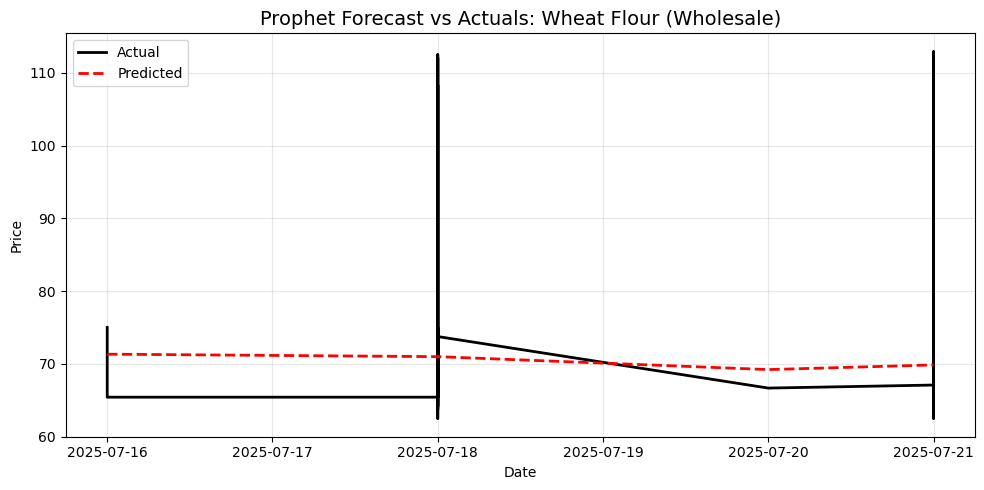

16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing


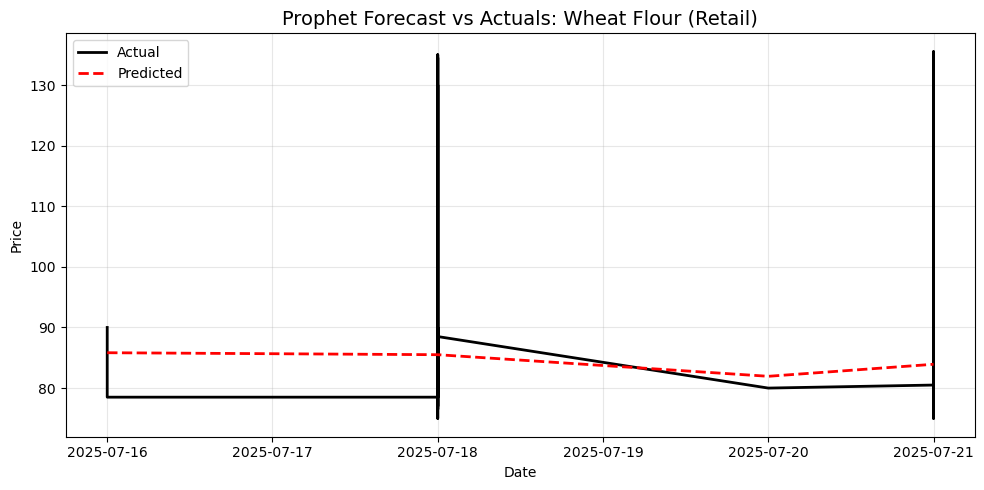

16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing


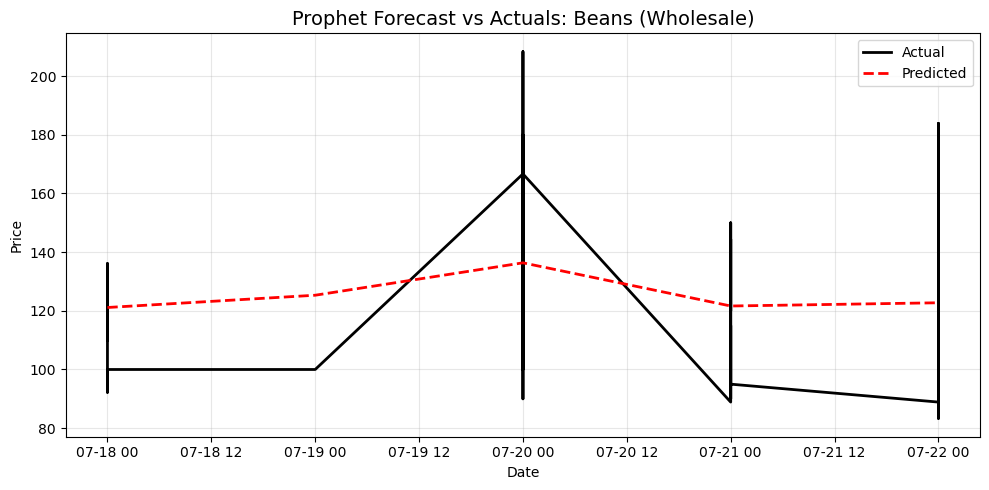

16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing


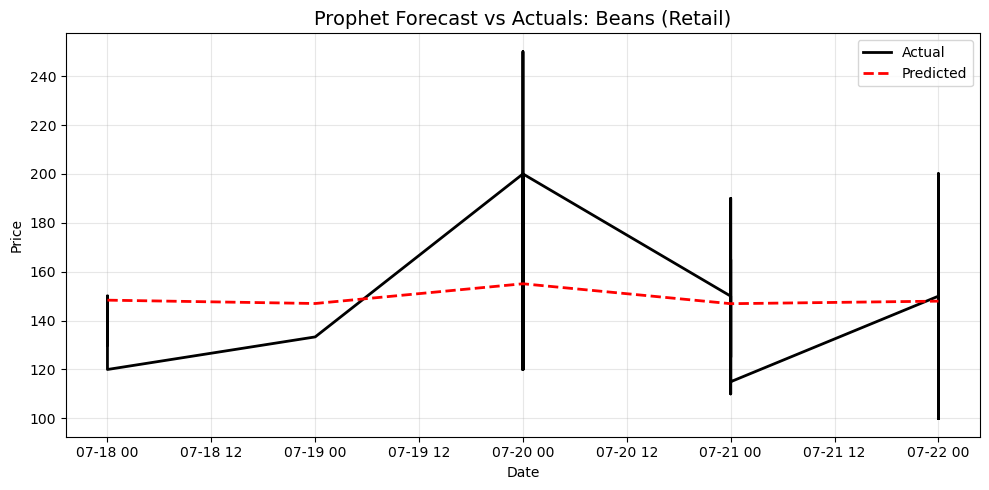

16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:30 - cmdstanpy - INFO - Chain [1] done processing


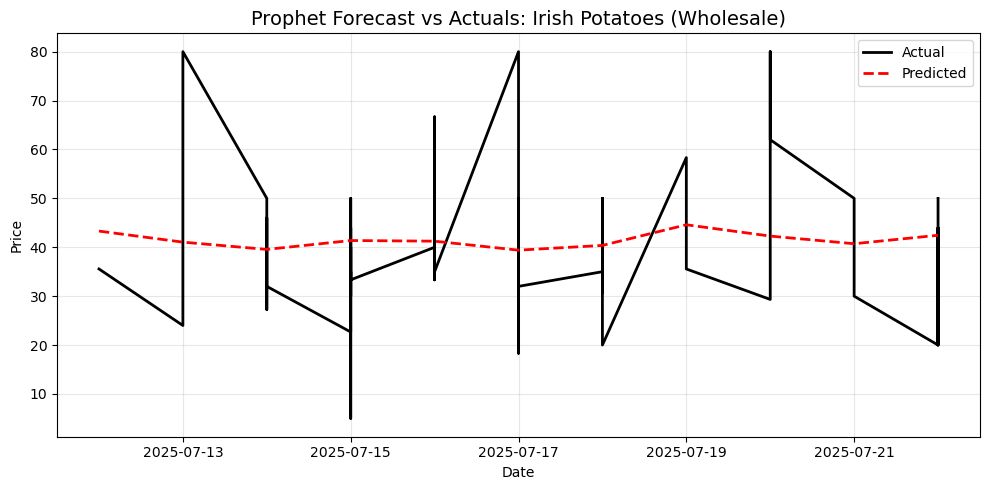

16:15:31 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing


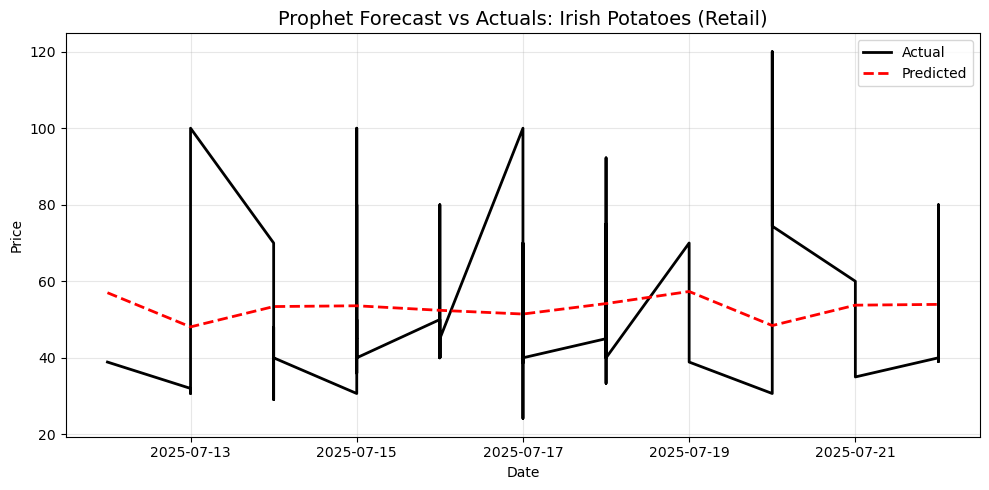

16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:15:34 - cmdstanpy - INFO - Chain [1] done processing


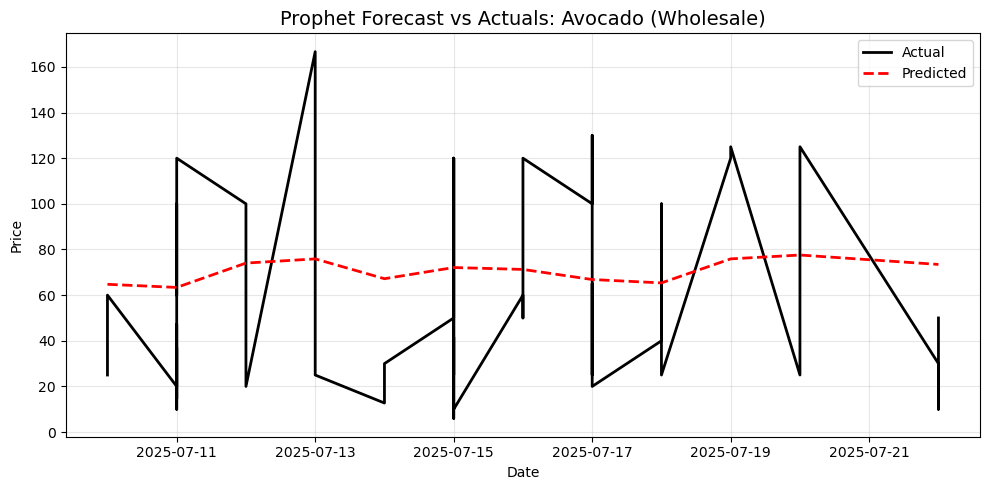

16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing


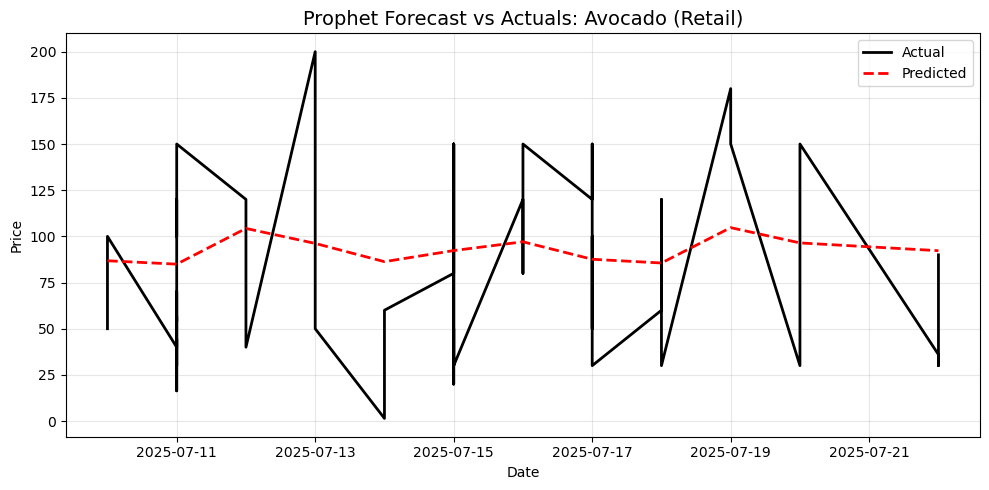

16:15:36 - cmdstanpy - INFO - Chain [1] start processing
16:15:36 - cmdstanpy - INFO - Chain [1] done processing


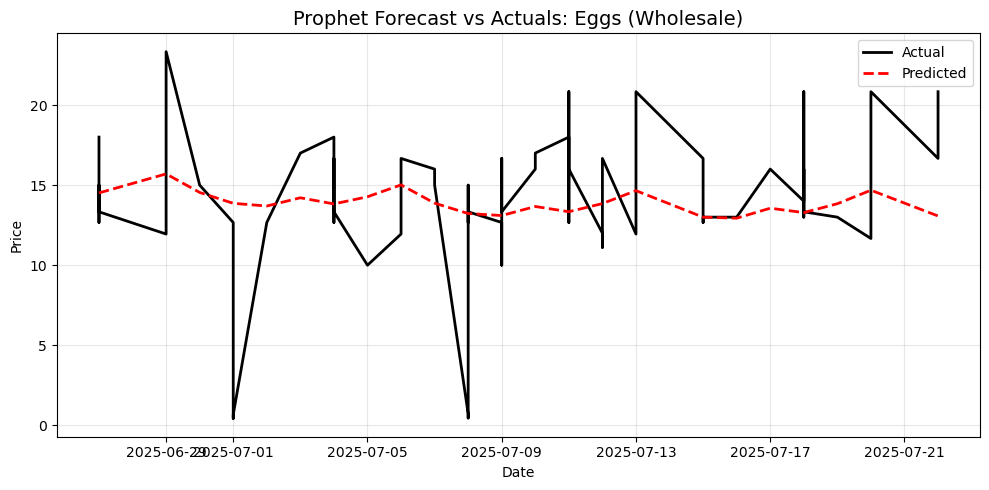

16:15:37 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing


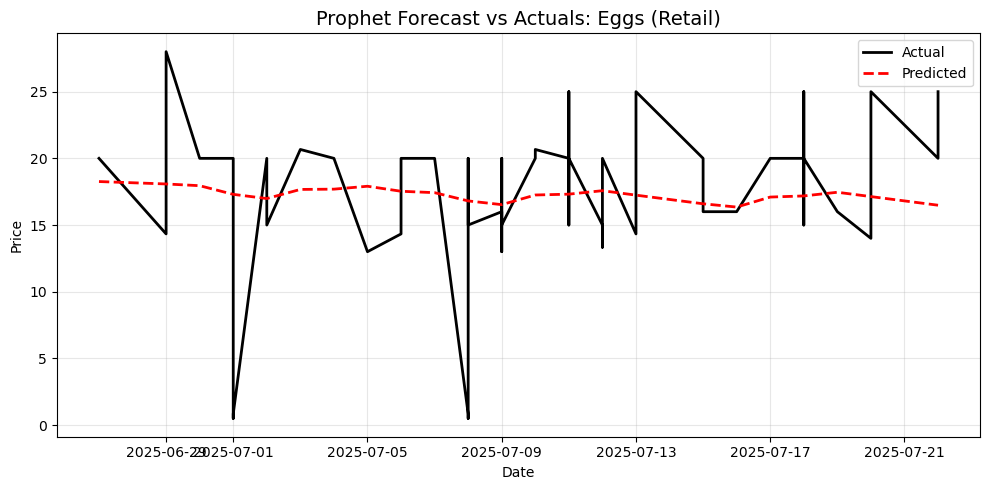

In [55]:
# Visualize Prophet predictions vs actuals for the top 5 commodities
for commodity in accuracy_df["Commodity"].unique():
    for price_col, price_type in [("WholesaleUnitPrice", "Wholesale"), ("RetailUnitPrice", "Retail")]:
        
        # Prepare series
        df_series = df_p[df_p["Commodity"] == commodity][["Date", price_col]].rename(
            columns={"Date": "ds", price_col: "y"}
        ).dropna().sort_values("ds")
        
        if len(df_series) < 90:
            continue
        
        # Train/test split (last 60 days as test)
        train = df_series.iloc[:-60]
        test = df_series.iloc[-60:]
        
        # Fit Prophet and forecast
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.fit(train)
        future = model.make_future_dataframe(periods=60, freq='D')
        forecast = model.predict(future)
        
        # Align dates
        forecast["ds"] = pd.to_datetime(forecast["ds"])
        test["ds"] = pd.to_datetime(test["ds"])
        
        # Align predictions with test dates
        pred_test = forecast.set_index("ds").reindex(test["ds"])["yhat"].reset_index(drop=True)
        actual_test = test["y"].reset_index(drop=True)
        
        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(test["ds"], actual_test, label="Actual", color="black", linewidth=2)
        plt.plot(test["ds"], pred_test, label="Predicted", color="red", linestyle="--", linewidth=2)
        
        plt.title(f"Prophet Forecast vs Actuals: {commodity} ({price_type})", fontsize=14)
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


### Top 5 commodities by record count


In [56]:
top_commodities = df_p["Commodity"].value_counts().head(5).index

results = []

for commodity in top_commodities:
    for price_col, price_type in [("WholesaleUnitPrice", "Wholesale"), ("RetailUnitPrice", "Retail")]:
        
        # Prepare series
        df_series = df_p[df_p["Commodity"] == commodity][["Date", price_col]].rename(
            columns={"Date": "ds", price_col: "y"}
        ).dropna().sort_values("ds")
        
        # Skipping the  short series
        if len(df_series) < 90:
            continue
        
        # Train/test split (last 60 days as test)
        train = df_series.iloc[:-60]
        test = df_series.iloc[-60:]
        
        # Fit Prophet
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.fit(train)
        future = model.make_future_dataframe(periods=60, freq='D')
        forecast = model.predict(future)
        
        # Align predictions
        forecast["ds"] = pd.to_datetime(forecast["ds"])
        test["ds"] = pd.to_datetime(test["ds"])
        pred_test = forecast.set_index("ds").reindex(test["ds"])["yhat"].reset_index(drop=True)
        actual_test = test["y"].reset_index(drop=True)
        
        # Clean NaNs
        mask = (~pred_test.isna()) & (~actual_test.isna())
        pred_test = pred_test[mask]
        actual_test = actual_test[mask]
        
        # Metrics
        mae = mean_absolute_error(actual_test, pred_test)
        rmse = mean_squared_error(actual_test, pred_test, squared=False)
        mape = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100
        r2 = r2_score(actual_test, pred_test)
        
        results.append({
            "Commodity": commodity,
            "Price_Type": price_type,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape,
            "R²": r2
        })

# Results sorted by R² (best performing first)
accuracy_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print(accuracy_df)


16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:46 - cmdstanpy - INFO - Chain [1] done processing
16:15:48 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:58 - cmdstanpy - INFO - Chain [1] done processing
16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:00 - cmdstanpy - INFO - Chain [1] start processing
16:16:00 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1]

        Commodity Price_Type        MAE       RMSE    MAPE (%)        R²
0           Beans  Wholesale  22.758837  26.764619   19.927779  0.086542
9         Avocado     Retail  41.355144  46.563317  178.432141  0.034457
1           Beans     Retail  27.417594  32.518259   19.374334  0.033682
7            Eggs     Retail   4.012319   5.547659  190.376562  0.017065
6            Eggs  Wholesale   3.131544   4.551923  174.483493  0.014832
2  Irish Potatoes  Wholesale  11.671506  14.795235   42.368362 -0.006661
8         Avocado  Wholesale  37.159448  40.864529  133.805295 -0.009797
5     Wheat Flour     Retail   9.170609  16.223309    8.975597 -0.032441
4     Wheat Flour  Wholesale   7.615836  13.550964    8.916713 -0.037264
3  Irish Potatoes     Retail  16.977539  21.333531   32.075046 -0.065596


- Poorly performing model, so we opted to try LSTM.